# Bayesian Spatiotemporal Graph Transformer Network (B-STAR) for Multi-Aircraft Trajectory Prediction


## Part 3: Testset Visualization

Author: Yutian Pang, Arizona State University

Email: yutian.pang@asu.edu

### Environment Requirements

This file is test functional with,
- Ubuntu 20.04 LTS
- Python 3.8.5 with Anaconda
- Google Cloud API key

The required packages are, 
- Pickle
- Matplotlib
- Numpy
- Bokeh 
(Note: Bokeh's GMaps function requires you to obtain and enable an Google Map Cloud API key at https://developers.google.com/maps/documentation/javascript/get-api-key)

In [1]:
api_key = 'YOUR GOOGLE CLOUD API KEY HERE'

### Load Data
- frameped_dict: 
    - dataset_index
    - frame_index
    - aircraft index list
- trajec_dict:
    - dataset_index
    - aircraft index
    - trajectories

In [2]:
import pickle

In [3]:
def load_cache(data_file):
    f = open(data_file, 'rb')
    raw_data = pickle.load(f)
    f.close()
    return raw_data
def load_dict(data_file):
    f = open(data_file, 'rb')
    raw_data = pickle.load(f)
    f.close()
    frameped_dict = raw_data[0]
    traject_dict = raw_data[1]

    return frameped_dict, traject_dict

In [4]:
# train_data_file = "test_result/train_trajectories.cpkl"
# train_batch_cache = "test_result/train_batch_cache.cpkl"
# train_frameped_dict, train_pedtraject_dict = load_dict(train_data_file)
# trainbatch, trainbatchnums, _, _ = load_cache(train_batch_cache)

test_data_file = "test_result/test_trajectories.cpkl"
test_batch_cache = "test_result/test_batch_cache.cpkl"
test_frameped_dict, test_traject_dict = load_dict(test_data_file)
testbatch, testbatchnums, _, _ = load_cache(test_batch_cache)

## Load a Pre-trained model outputs
- The model is trained with $t_{obs}=8$, $t_{pred}=12$
- Training 2,000 epochs, best performance reached at epoch 1872.
    - Best_ADE=0.011, Best_FDE=0.022 at Epoch 1872

In [5]:
pred_batch_cache = "test_result/all_output_1872.cpkl"
result= load_cache(pred_batch_cache)

In [6]:
print("Number of Batch in Testset: {}".format(len(testbatch)))

Number of Batch in Testset: 2


### Show Neighbors within batch of data

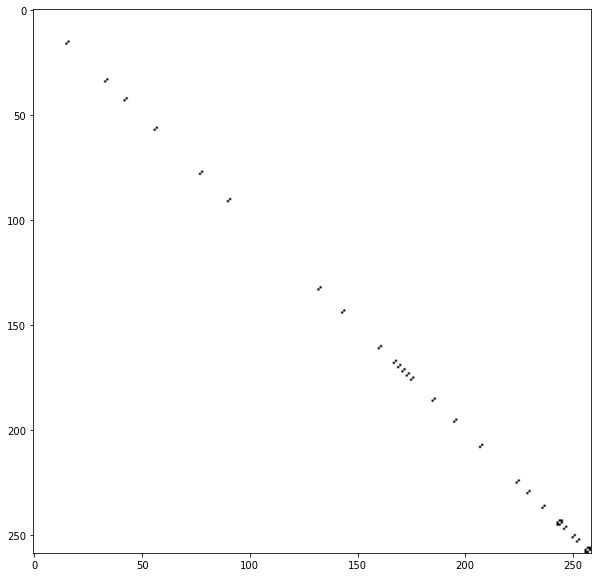

In [7]:
i_batch_number = 0
batch_data, batch_id = testbatch[i_batch_number]

nodes_batch_b, seq_list_b, nei_list_b, nei_num_b, batch_pednum = batch_data

import matplotlib.pyplot as plt 
import matplotlib.cm as cm
plt.figure(figsize=(10, 10))
plt.imshow(nei_list_b[0], cmap=cm.binary, aspect='auto')

In [8]:
nodes_batch_b.shape

(20, 259, 2)

### The neighbors (group of trajectories) selected to display
- idx_start
    - trajectory start index
- idx_end
    - trajectory end index   

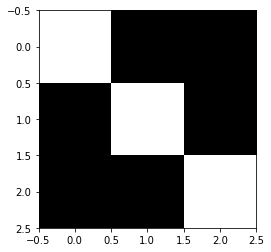

In [9]:
idx_start = 243
idx_end = 246
plt.imshow(nei_list_b[0][idx_start:idx_end,idx_start:idx_end],cmap=cm.binary)

# Gound Truth Visualization

### Plot the Entire Batch

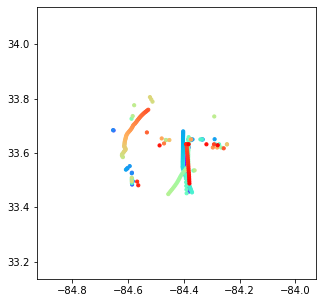

In [10]:
from IPython.display import clear_output
from matplotlib import cm
import time
import numpy as np
import time

colors = cm.rainbow(np.linspace(0, 1, nodes_batch_b.shape[1]))
for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-0.5,-84.4278640+0.5,33.6366996-0.5,33.6366996+0.5])
    
    plt.scatter(*nodes_batch_b[i].T, c=colors, s=10)  
    plt.show()
    time.sleep(0.1)
    
buffer_groud_truth = nodes_batch_b

In [11]:
import bokeh
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="roadmap", zoom=11)
p = gmap(api_key, map_options, title="KATL")

for i in range(buffer_groud_truth.shape[1]):
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="white", fill_alpha=0.8)
    #p.line(x=lat, y=lon, line_width=2)

show(p)

Loading BokehJS ...

### Plot the Selected Neighbors Data

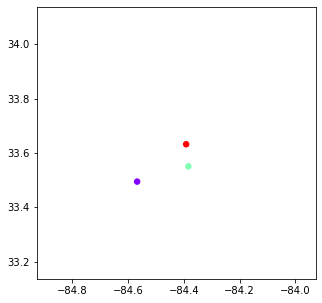

In [12]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer_groud_truth = nodes_batch_b[:,idx_start:idx_end,:]
colors = cm.rainbow(np.linspace(0, 1, buffer_groud_truth.shape[1]))

for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-0.5,-84.4278640+0.5,33.6366996-0.5,33.6366996+0.5])
    plt.scatter(*buffer_groud_truth[i].T, c=colors, s=30)
    plt.show()
    time.sleep(0.1)

In [13]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="roadmap", zoom=11)
p = gmap(api_key, map_options, title="KATL")

for i in range(buffer_groud_truth.shape[1]):
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="red", fill_alpha=0.8)
    #p.line(x=lat, y=lon, line_width=2)

show(p)

Loading BokehJS ...

### The Data Feeded into B-STAR Training
- Shifting is performed to the original data

In [14]:
def rotate_shift_batch(batch_data, ifrotate=True):
    '''
    Random ration and zero shifting.
    '''
    batch, seq_list, nei_list, nei_num, batch_pednum = batch_data

    # rotate batch
    if ifrotate:
        th = random.random() * np.pi
        cur_ori = batch.copy()
        batch[:, :, 0] = cur_ori[:, :, 0] * np.cos(th) - cur_ori[:, :, 1] * np.sin(th)
        batch[:, :, 1] = cur_ori[:, :, 0] * np.sin(th) + cur_ori[:, :, 1] * np.cos(th)
        
    # get shift value
    s = batch[11 - 1]

    shift_value = np.repeat(s.reshape((1, -1, 2)), 20, 0)
    batch_data = batch, batch - shift_value, shift_value, seq_list, nei_list, nei_num, batch_pednum
    return batch_data

In [15]:
batch_data_b = rotate_shift_batch(batch_data, ifrotate=False)

In [16]:
batch_abs, batch_norm, shift_value, seq_list, nei_list, nei_num, batch_pednum = batch_data_b

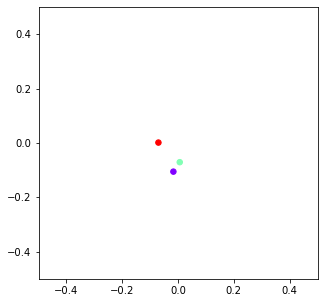

In [17]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer = batch_norm[:,idx_start:idx_end,:]
colors = cm.rainbow(np.linspace(0, 1, buffer.shape[1]))

for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-0.5, 0.5, -0.5, 0.5])
    plt.scatter(*buffer[i].T, c=colors, s=30) 
    plt.show()

# Test Result

### Shift the prediction back to the orginal range

In [18]:
shift_value.shape

(20, 259, 2)

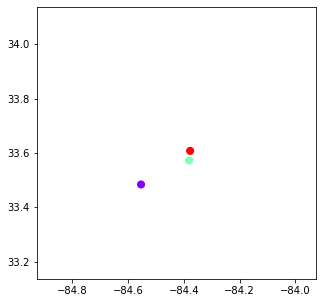

In [19]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer_pred = result['test_mean'][i_batch_number][:,idx_start:idx_end,:].cpu() + shift_value[1:,idx_start:idx_end,:]

aa = np.array(result['test_mean'][i_batch_number].cpu())
colors = cm.rainbow(np.linspace(0, 1, buffer_pred.shape[1]))

for i in range(19):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-0.5,-84.4278640+0.5,33.6366996-0.5,33.6366996+0.5])
    plt.scatter(*buffer_pred[i].T, c=colors, s=50) 
    #plt.axis([np.min(aa[:,idx_start:idx_end,0])-1,np.max(aa[:,idx_start:idx_end,0])+1,np.min(aa[:,idx_start:idx_end,1])-1,np.max(aa[:,idx_start:idx_end,1])+1])
    plt.show()
    time.sleep(0.1)

In [20]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="roadmap", zoom=11)
p = gmap(api_key, map_options, title="KATL")

for i in range(buffer_pred.shape[1]):
    lat = buffer_pred[:, i, 0].tolist()
    lon = buffer_pred[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="red", fill_alpha=0.8, legend_label='Prediction Mean')
    #p.line(x=lat, y=lon, line_width=2)
    
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="blue", fill_alpha=0.8, legend_label='Ground Truth')
    p.legend.location = "top_left"

show(p)

Loading BokehJS ...

### Prediction with Confidence Ellipse, after shifting

In [21]:
buffer.shape

(20, 3, 2)

In [22]:
result['test_var'][i_batch_number][:,idx_start:idx_end,:].cpu().shape

torch.Size([19, 3, 2])

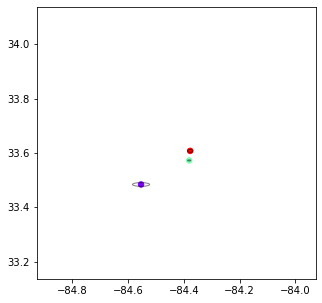

In [23]:
from IPython.display import clear_output
from matplotlib import cm
import time
from matplotlib.patches import Ellipse

mean =result['test_mean'][i_batch_number][:,idx_start:idx_end,:].cpu() + shift_value[1:,idx_start:idx_end,:]
std = np.sqrt(result['test_var'][i_batch_number][:,idx_start:idx_end,:].cpu())

aa = np.array(result['test_mean'][i_batch_number].cpu())
colors = cm.rainbow(np.linspace(0, 1, mean.shape[1]))

for i in range(19):
    clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-0.5,-84.4278640+0.5,33.6366996-0.5,33.6366996+0.5])
    plt.scatter(*buffer_pred[i].T, c=colors, s=30) 
    
    # draw confidence ellipse
    ells = [Ellipse(xy=[mean[i, j, 0], mean[i, j, 1]], width = 3 * std[i, j, 0], height = 3 * std[i, j, 1], 
                           angle=0, fill=False)
#                 angle=90-np.rad2deg(
#                     np.arctan((self.pred_traj_mean[idx, i, 0] - self.pred_traj_mean[idx, i-1, 0]) /
#                               (self.pred_traj_mean[idx, i, 1] - self.pred_traj_mean[idx, i-1, 1]))))
           for j in range(mean.shape[1])]
    
#     for e in ells:
#         ax.add_artist(e)
#         e.set_clip_box(ax.bbox)
#         e.set_alpha(1)
#         e.set_facecolor('r')
    
    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.5)
        #e.set_facecolor('b')
    
    #plt.axis([np.min(aa[:,idx_start:idx_end,0])-1,np.max(aa[:,idx_start:idx_end,0])+1,np.min(aa[:,idx_start:idx_end,1])-1,np.max(aa[:,idx_start:idx_end,1])+1])
    plt.show()
    time.sleep(0.2)

## Verification of Prediction Variance 
### Increasing since $t_{obs}=8$

In [24]:
t_obs = 8
t_all = 20

Text(0.5, 1.0, 'Latitude in degrees')

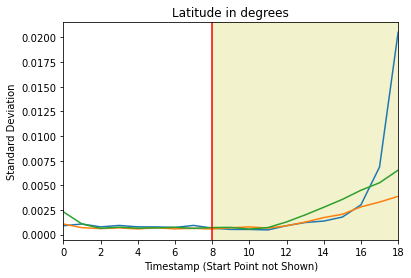

In [25]:
fig, ax = plt.subplots()
plt.plot(np.array(std[:, :, 0]))
#plt.plot(np.array(result['test_var'][i_batch_number][:, idx_start:idx_end, 0].cpu()))
plt.axvline(x=t_obs, ymin=0, ymax=1, c='red')
ax.axvspan(0, t_obs, alpha=0.1, color='w')
ax.axvspan(t_obs, t_all-2, alpha=0.2, color='y')
plt.xlim(0, t_all-2)
plt.xlabel('Timestamp (Start Point not Shown)')
plt.ylabel('Standard Deviation')
plt.title('Latitude in degrees')

Text(0.5, 1.0, 'Longitude in degrees')

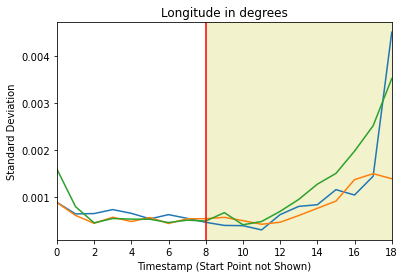

In [26]:
fig, ax = plt.subplots()
plt.plot(np.array(std[:, :, 1]))
#plt.plot(np.array(result['test_var'][i_batch_number][:, idx_start:idx_end, 0].cpu()))
plt.axvline(x=t_obs, ymin=0, ymax=1, c='red')
ax.axvspan(0, t_obs, alpha=0.1, color='w')
ax.axvspan(t_obs, t_all-2, alpha=0.2, color='y')
plt.xlim(0, t_all-2)
plt.xlabel('Timestamp (Start Point not Shown)')
plt.ylabel('Standard Deviation')
plt.title('Longitude in degrees')